In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
import zipfile
import os

with zipfile.ZipFile("Musical Instrument.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


# Load the dataset from folder
Label the data, resize it and reshuffle the data

In [3]:
data_dir='/content/music_instruments'
image_size=(224,224)
batch_size=32  # Dataset would be loaded in 32 batch size to save time and memory instead of loading the data 1 by 1

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,  # seed=42 ensures the split between train and validation is always the same
    image_size=image_size,
    batch_size=batch_size

)

validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 1806 files belonging to 10 classes.
Using 1445 files for training.
Found 1806 files belonging to 10 classes.
Using 361 files for validation.


In [4]:
class_name=train_ds.class_names
print(class_name)

['accordion', 'banjo', 'drum', 'flute', 'guitar', 'harmonica', 'saxophone', 'sitar', 'tabla', 'violin']


# Optimizing the Code


In [5]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cacheStores the dataset in memory (or disk) after the first epoch.
# Why: So it doesn’t read and preprocess the images again in every epoch — saves time! and prefetch  Allows the model to fetch the next batch while the current one is being processed. and speeds up data preparation
validation_ds=validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation
Data augmentation creates slightly modified versions of your training images on-the-fly (during training) to:

1. Reduce overfitting.

2. Improve generalization.

3. Make the model more robust to real-world variations

In [6]:
data_augmentation=models.Sequential([  #The Sequential() model expects a list of layers in order to esecute in orderwise
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomZoom(0.1,),
    layers.RandomRotation(0.1)
])

In [7]:
# we use prepare_ds fun to perform augmentation and optimization at one step

AUTOTUNE=tf.data.AUTOTUNE  # Buffer to speed things up

def prepare_ds(ds,augment=False):
    ds=ds.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=AUTOTUNE) if augment else ds
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds=prepare_ds(train_ds,augment=True)  # Training set gets augmented because it's meant to learn from variety.
validation_ds=prepare_ds(validation_ds)   # Validation set is left untouched so you can evaluate performance on real data without randomness.


# Custom CNN Model

In [8]:
model=models.Sequential([
    #  Preprocessing Layers
    layers.Rescaling(1./255,input_shape=(224,224,3)),

    #Cov Layers + Max Pooling
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D(),  # Reduces image size by keeping only the most important features.

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128,activation='relu'), #A fully connected layer with 128 neurons to learn complex patterns.
    layers.Dropout(0.3), # Randomly turns off 30% of neurons during training to prevent overfitting.
    layers.Dense(len(class_name),activation='softmax') # softmax turns raw scores into probabilities for each class.

    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=('sparse_categorical_crossentropy'),optimizer=optimizer,metrics=['accuracy'])

In [17]:
# Bascically checkpoint saves the best model based on accuracy
checkpoint_cb=ModelCheckpoint('best_model.h5',
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')

# Early stopping stops training early to avoid overfiting
early_stopping_cb=EarlyStopping(patience=5, #patience is a method Waits for 5 epochs without improvement before reducing.
                                restore_best_weights=True,
                                monitor='val_accuracy',
                                mode='min')
# Helps fine-tune the model when it's stuck and not improving.
reduce_lr_cb=ReduceLROnPlateau(patience=3,monitor='val_loss',factor=0.2,min_lr=1e-6)

callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr_cb]

In [18]:
history=model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1998 - loss: 2.1587

46/46 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.2002 - loss: 2.1582 - val_accuracy: 0.2659 - val_loss: 2.0375 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2866 - loss: 2.0274

46/46 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.2867 - loss: 2.0272 - val_accuracy: 0.3850 - val_loss: 1.9328 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.3184 - loss: 1.9025 - val_accuracy: 0.3767 - val_loss: 1.8262 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.3360 - loss: 1.8704 - val_accuracy: 0.3657 - val_loss: 1.8477 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.3626 - loss: 1.8109 - val_accuracy: 0.3740 - val_loss: 1.7655 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3971 - loss: 1.7613

46/46 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.3969 - loss: 1.7611 - val_accuracy: 0.4321 - val_loss: 1.6214 - learning_rate: 0.0010


In [15]:
def plot_training_history(history):

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


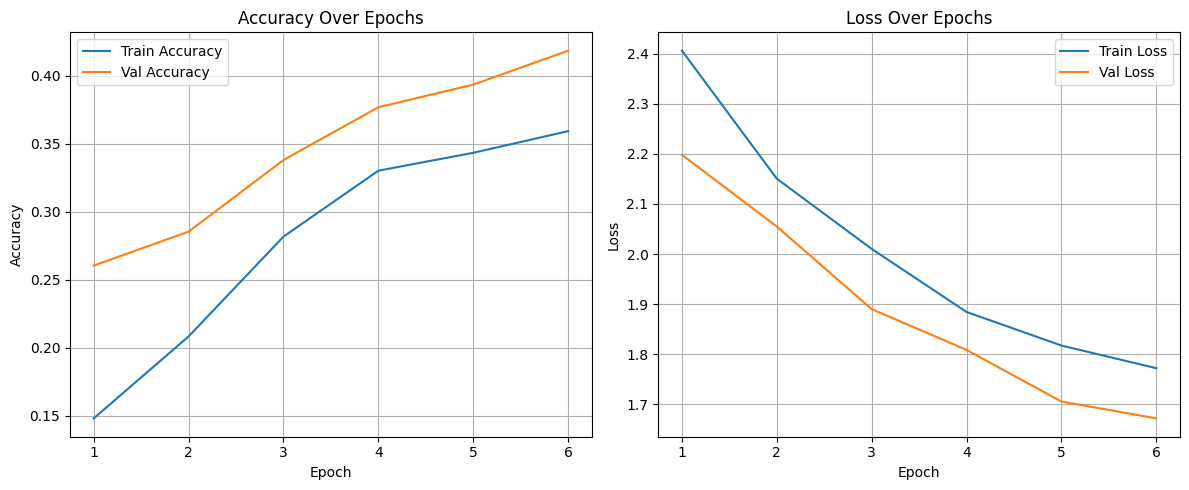

In [16]:
plot_training_history(history)